## Imports

In [1]:
!pip install rembg==2.0.56 -q

In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

## Image Pipeline

In [12]:
class ImageModel:
    def __init__(
        self,
        rgb_img,
        mask_img,
        key_contour=None,
        cropped_mask=None,
        cropped_feature=None,
    ):
        self.rgb_img = rgb_img
        self.mask_img = mask_img
        self.key_contour = key_contour
        self.cropped_mask = cropped_mask
        self.cropped_feature = cropped_feature


def fix_image_size(image):
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    canvas[
        offset_y : offset_y + image.shape[0], offset_x : offset_x + image.shape[1]
    ] = image

    return canvas


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension

    original_height, original_width = image.shape[:2]

    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    scale = min(scale_x, scale_y)

    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    canvas = np.zeros((HEIGHT + 2 * PADDING, WIDTH + 2 * PADDING), dtype=np.uint8)

    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    canvas[
        offset_y : offset_y + resized_image.shape[0],
        offset_x : offset_x + resized_image.shape[1],
    ] = resized_image

    return canvas


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90

    return (new_angle + 180) if is_below else (new_angle + 180)


def load_general_use_model():
    model_name = "isnet-general-use"
    return new_session(model_name)


def remove_bg(input_img, only_mask=False):
    model_session = load_general_use_model()

    return remove(
        data=input_img,
        only_mask=only_mask,
        session=model_session,
    )


def contrast_using_dynamic_gamma(image):
    """
    Dynamically adjust the gamma value of an image based on its mean pixel intensity.
    """
    mean_intensity = np.mean(image)

    # Determine the gamma value based on mean intensity
    # You can adjust these thresholds and gamma values based on your requirements
    if mean_intensity < 50:
        gamma = 2.5  # Very dark image
    elif mean_intensity < 100:
        gamma = 2.0  # Dark image
    elif mean_intensity < 150:
        gamma = 2.0  # 1.5 - Slightly dark image
    elif mean_intensity < 200:
        gamma = 1.7  # 1.0 - Normal image
    else:
        gamma = 0.5  # Bright image

    invGamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")
    return cv2.LUT(image, table), gamma


def image_processing_pipeline(original_image):
    # 1. Read img as RGB
    rgb_img = np.array(original_image)

    # 2. Convert RGB to Grayscale and create an empty img of same dimension
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    grayscale_img, _ = contrast_using_dynamic_gamma(grayscale_img)

    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 3. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 4. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Cropped masked img
    contours, _ = cv2.findContours(
        mask_img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE,
    )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y : y + h, x : x + w]

    # 6. Extract and paste only region of interest to grayscale image
    thickness = int((rgb_img.shape[0] + rgb_img.shape[1]) / 200)
    cv2.drawContours(empty_img, contours, -1, (255), thickness=thickness)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)

    # 7. Make model object
    img_model = ImageModel(
        rgb_img=np.array(rgb_img),
        mask_img=mask_img,
        cropped_mask=cropped_mask,  # Useless
        cropped_feature=cropped_feature,  # Useless right now
        key_contour=contours[0],
    )

    # 8. Rotate key inside the image by fitting ellipse
    ellipse = cv2.fitEllipse(img_model.key_contour)
    center, _, current_angle = ellipse
    
    plt_ellipse(cropped_feature, ellipse)

    is_below = center[1] > img_model.mask_img.shape[1] / 2
    rotation_angle = get_rotation_angle(is_below, current_angle)

    # 9. Resize mask and grayscale image before applying rotation
    resized_binary_image = fix_image_size(img_model.mask_img)
    resized_grayscale_image = fix_image_size(img_model.cropped_feature)

    # 10. Apply rotation
    center = (resized_binary_image.shape[1] // 2, resized_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    rotated_binary_image = cv2.warpAffine(
        resized_binary_image,
        rot_mat,
        resized_binary_image.shape[1::-1],
    )

    rotated_grayscale_image = cv2.warpAffine(
        resized_grayscale_image,
        rot_mat,
        resized_grayscale_image.shape[1::-1],
    )

    # 11. Cropped the rotated masked img
    contours, _ = cv2.findContours(
        rotated_binary_image,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE,
    )

    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    x, y, w, h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y : y + h, x : x + w]
    rotated_grayscale_image = rotated_grayscale_image[y : y + h, x : x + w]

    # 12. Updated cropped masked
    img_model.cropped_mask = rotated_binary_image
    img_model.cropped_feature = rotated_grayscale_image

    # 13. Resized cropped feature to 256x256
    rezised_feature = resize_grayscale_image(
        img_model.cropped_feature,
        (232, 232, 12),
    )

    _, binarized = cv2.threshold(rezised_feature, 1, 255, cv2.THRESH_BINARY)

    return binarized

def plt_ellipse(image, ellipse):
    # Draw the ellipse on the image
    cv2.ellipse(image, ellipse, (0, 255, 0), 20)

    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt_img(image_rgb)

## New Pipeline

In [36]:
def load_general_use_model():
    model_name = "isnet-general-use"
    return new_session(model_name)


def remove_bg(input_img, only_mask=False):
    return remove(
        data=input_img,
        only_mask=only_mask,
        session=load_general_use_model(),
    )

def contrast_using_dynamic_gamma(image):
    mean_intensity = np.mean(image)
    if mean_intensity < 50:
        gamma = 2.5  # Very dark image
    elif mean_intensity < 100:
        gamma = 2.0  # Dark image
    elif mean_intensity < 150:
        gamma = 2.0  # 1.5 - Slightly dark image
    elif mean_intensity < 200:
        gamma = 1.7  # 1.0 - Normal image
    else:
        gamma = 0.5  # Bright image

    invGamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")
    return cv2.LUT(image, table), gamma

def split_image(image, factor):
    width = image.shape[1]
    left = image[:, : int(width * factor)]
    right = image[:, int(width * factor) :]
    return left, right

def plt_img(img_data, cmap="viridis"):
    plt.imshow(img_data, cmap)
    plt.axis('on')
    plt.show()

def preprocessing(image):
    
    rgb_image = np.array(image)
    
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY) 
    gray_image, _ = contrast_using_dynamic_gamma(gray_image)
    
    empty_image = np.zeros_like(gray_image, dtype=np.uint8)
    gray_mask = np.array(remove_bg(gray_image, only_mask=True))
    _, bin_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        bin_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE,
    )
    
    outline = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    
    thickness = int((rgb_image.shape[0] + rgb_image.shape[1]) / 200)
    cv2.drawContours(empty_image, [outline], -1, (255), thickness=thickness)
    
    largest_contour = outline
    image = empty_image

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine if the image is vertical or horizontal
    if h > w:
        orientation = 'vertical'
    else:
        orientation = 'horizontal'

    # Find the leftmost and rightmost points
    leftmost = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
    rightmost = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])

    # Find the topmost and bottommost points
    topmost = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
    bottommost = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])

    # Calculate the center and endpoint based on orientation
    if orientation == 'vertical':
        # Center point is the mid of leftmost and rightmost points
        center = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
        # Endpoint is the topmost point
        endpoint = topmost
        
    else:
        # Center point is the mid of topmost and bottommost points
        center = ((topmost[0] + bottommost[0]) // 2, (topmost[1] + bottommost[1]) // 2)
        # Endpoint is the rightmost point
        endpoint = rightmost

    # Calculate the angle to rotate
    delta_x = endpoint[0] - center[0]
    delta_y = endpoint[1] - center[1]
    angle = math.degrees(math.atan2(delta_y, delta_x))

    # Correct the angle for rotation
    if orientation == 'vertical':
        angle = -angle
    else:
        angle = -(angle - 90)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1.0)

    # Rotate the image
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC, 
                                   borderMode=cv2.BORDER_REPLICATE)

    # Transform the center and endpoint points
    center_rotated = cv2.transform(np.array([[center]], dtype=np.float32), M)[0][0]
    endpoint_rotated = cv2.transform(np.array([[endpoint]], dtype=np.float32), M)[0][0]

    # Convert the transformed points to integer
    center_rotated = tuple(map(int, center_rotated))
    endpoint_rotated = tuple(map(int, endpoint_rotated))

    # Draw the center line on the rotated image
    cv2.line(rotated_image, center_rotated, endpoint_rotated, (255, 0, 0), 25)  # Blue color with thicker line (5 px)

    plt_img(rotated_image)

## Loading and Processing

In [14]:
filepaths, images = [], []
BASE_PATH = '/kaggle/input/key-images/'

for filename in os.listdir(BASE_PATH):
    if filename[0].isdigit():
        path = os.path.join(BASE_PATH, filename)
        filepaths.append(path)
        
filepaths.sort()
filepaths = filepaths[9:]

for filepath in filepaths:
    images.append(cv2.imread(filepath))

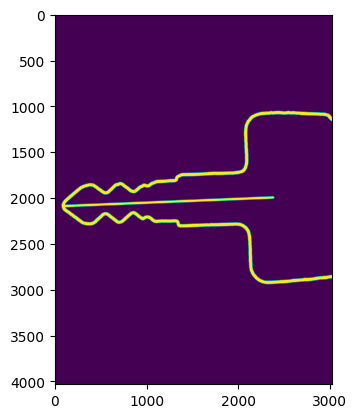

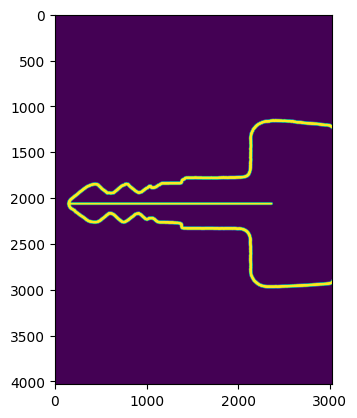

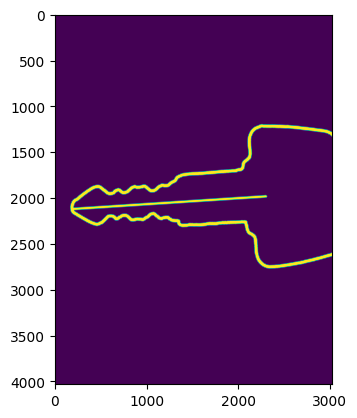

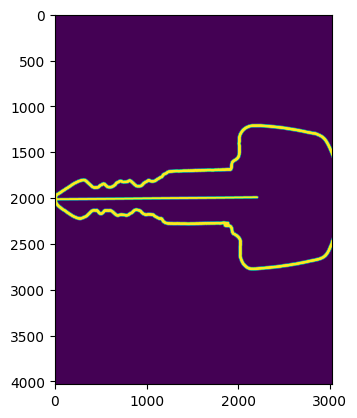

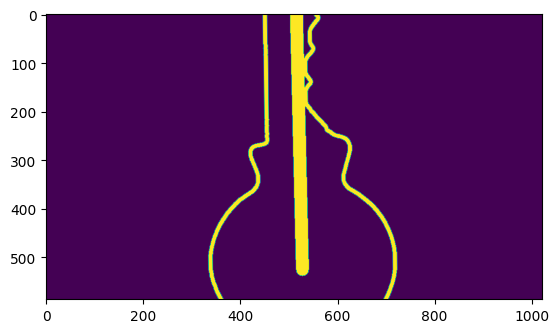

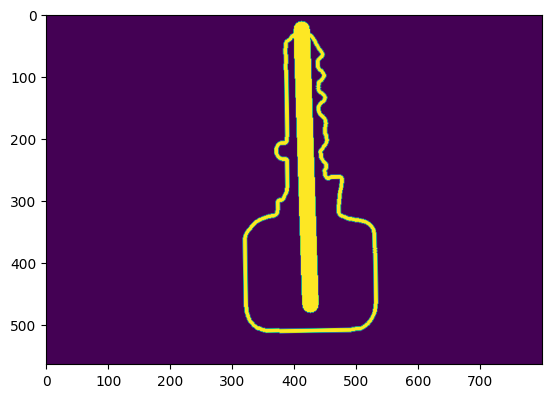

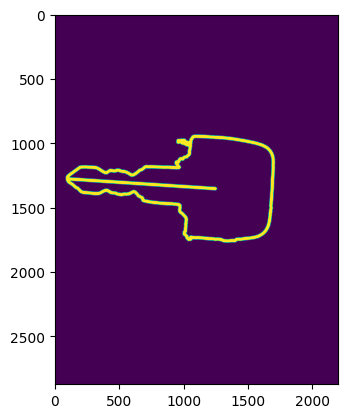

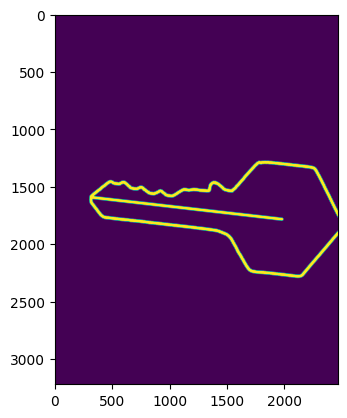

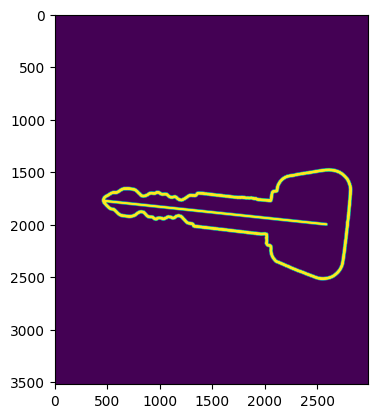

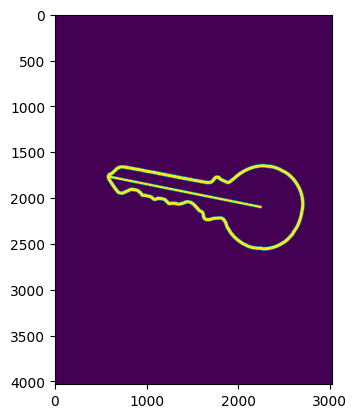

In [37]:
for image in images:
    preprocessing(image)

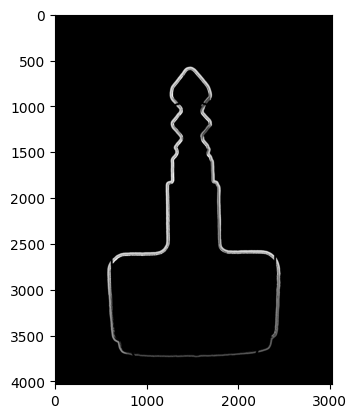

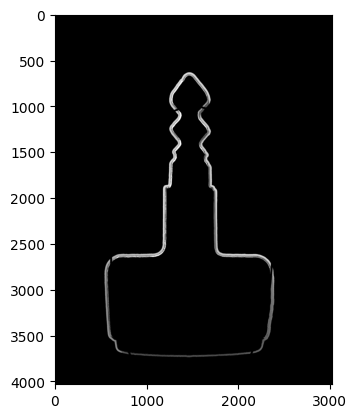

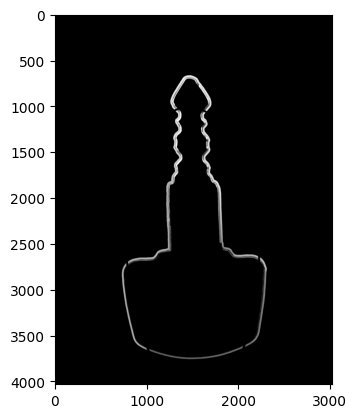

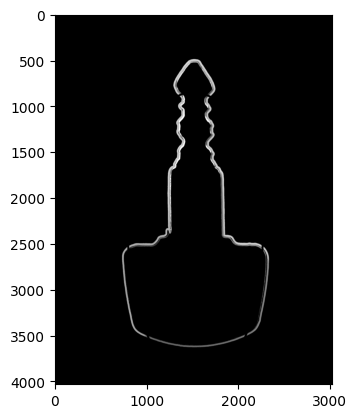

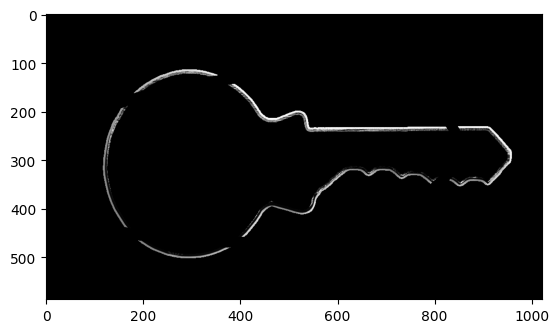

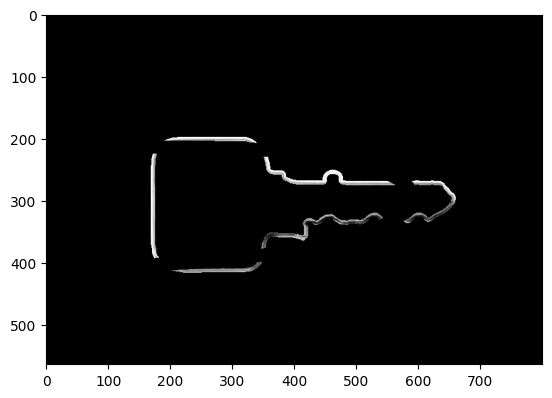

KeyboardInterrupt: 

In [16]:
skeletons = []

for image in images:
    image_processing_pipeline(image)

## Cosine Similarity

In [ ]:
def plot_cosine_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]
            confusion_matrix[i, j] = round(cosine_sim, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_cosine_similarity_score(skeletons, indexes)

## Hu Moments

In [ ]:
def plot_hu_moments_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            
             # Calculate moments
            moments1 = cv2.moments(images_data[i])
            moments2 = cv2.moments(images_data[j])

            # Calculate Hu moments
            huMoments1 = cv2.HuMoments(moments1).flatten()
            huMoments2 = cv2.HuMoments(moments2).flatten()

            # Compare Hu moments using Euclidean distance
            distance = np.linalg.norm(huMoments1 - huMoments2)

            confusion_matrix[i, j] = round(1 - distance, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_hu_moments_score(skeletons, indexes)

## Cosine Similarity Stress Testing

In [ ]:
import math
import random

def random_rotate_image(image, rand_range):
    height, width = image.shape[:2]

    # Generate a random rotation angle between -30 and 30 degrees
    angle = random.uniform(-rand_range, rand_range)

    # Calculate the rotation matrix
    center = (width / 2, height / 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the sine and cosine of the rotation angle
    cos_angle = abs(rot_matrix[0, 0])
    sin_angle = abs(rot_matrix[0, 1])

    # Compute the new bounding box dimensions
    new_width = int((height * sin_angle) + (width * cos_angle))
    new_height = int((height * cos_angle) + (width * sin_angle))

    # Adjust the rotation matrix to take into account the translation
    rot_matrix[0, 2] += (new_width / 2) - center[0]
    rot_matrix[1, 2] += (new_height / 2) - center[1]

    # Perform the rotation
    rotated_img = cv2.warpAffine(image, rot_matrix, (new_width, new_height))

    # Calculate the coordinates for cropping to the original size
    x = (new_width - width) // 2
    y = (new_height - height) // 2
    cropped_img = rotated_img[y:y + height, x:x + width]

    # Save the output image
    return cropped_img

In [ ]:
skewed_images = []

for image in skeletons:
    skewed = random_rotate_image(image, 5)
    skewed_images.append(skewed)
    plt_img(skewed, cmap="gray")

In [ ]:
def plot_skewed_cosine_similarity_score(images_data, index_array):
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

            confusion_matrix[i, j] = round(cosine_sim, 4)

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_cosine_similarity_score(skewed_images, indexes)

## SIFT

In [ ]:
def plot_SIFT_score(images_data, index_array):
    sift = cv2.SIFT_create()
    search_params = dict(checks=40)
    index_params = dict(algorithm=1, trees=5)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    MATCH_RATIO = 0.75
    all_keypoints = []
    all_descriptors = []

    for image in images_data:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        all_keypoints.append(keypoints), all_descriptors.append(descriptors)
    
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            matches = matcher.knnMatch(all_descriptors[i], all_descriptors[j], k=2)
            
            good_matches = []
            for m, n in matches:
                if m.distance < MATCH_RATIO * n.distance:
                    good_matches.append(m)

#             confusion_matrix[i, j] = len(matches) / min(
#                 len(all_descriptors[i]), 
#                 len(all_descriptors[j]),
#             )
            
            confusion_matrix[i, j] = len(good_matches) / len(all_descriptors[i])

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_SIFT_score(skeletons, indexes)